In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from catboost import CatBoostRegressor
from data.data_generator import generate_house_prices_dataset
import scipy.stats as stats
from scipy.stats import norm
from scipy.interpolate import UnivariateSpline
from scipy.integrate import cumulative_trapezoid
from sklearn import datasets
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from pygam import LinearGAM, s

In [35]:
house_prices_df = generate_house_prices_dataset(num_samples=5000, random_seed=42)
# Split the data into features and target
X = house_prices_df.drop('house_price', axis=1)
y = np.array(house_prices_df['house_price'])
# Define categorical features
cat_features = ['location_category', 'property_condition']
house_prices_df.head()

,square_feet,num_bedrooms,num_bathrooms,location_category,year_built,property_condition,house_price
0,1660,1,2,Suburban,1997,Fair,4.106339e+05
1,4572,5,3,Rural,1990,Excellent,1.039650e+06
2,3892,4,1,Suburban,2008,Good,8.929336e+05
3,1266,1,2,Rural,2016,Poor,2.699357e+05
4,4244,4,3,Urban,2015,Fair,1.032127e+06


In [38]:
# First split: 70% train, 30% temp (which will be split into val and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Second split: Split the temp set into validation and test (50% each, which is 15% of original data)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# # Scale the target variable
# scaler_y = MinMaxScaler()
# y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
# y_val = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
# y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Print the shapes to verify the splits
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 3500 samples
Validation set: 750 samples
Test set: 750 samples


(array([17.,  2.,  3.,  1.,  2.,  2.,  1.,  3.,  2., 17.]),
 array([1.48598099e-12, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

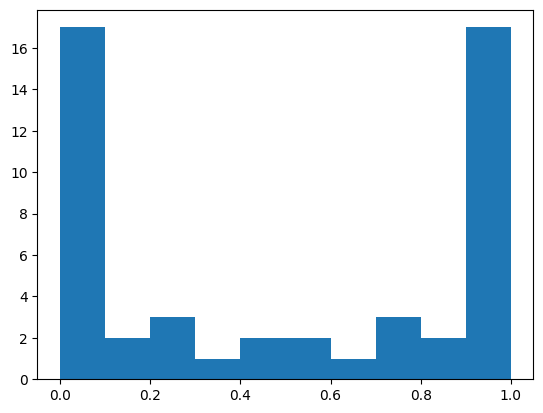

In [39]:
# Uniformly spaced quantiles
uniform_quantiles = np.linspace(0.01, 0.99, 50)

# Transform using normal distribution's PPF
non_uniform_quantiles = stats.norm.cdf(stats.norm.ppf(uniform_quantiles) * 3)

# Ensure values are within [0,1]
non_uniform_quantiles = np.clip(non_uniform_quantiles, 0, 1)

quantiles = non_uniform_quantiles
plt.hist(quantiles) 

In [40]:
multiquantile_loss_str = str(quantiles.astype(float)).replace("[", "").replace("]", "").replace("\n", "").replace(" ", ", ")
model = CatBoostRegressor(cat_features=cat_features, 
                          loss_function=f"MultiQuantile:alpha={multiquantile_loss_str}",
                          iterations=1000, 
                          subsample=1.0,
                          random_seed=42)
model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True, verbose=True)

0:	learn: 29544.7703762	test: 30098.0803332	best: 30098.0803332 (0)	total: 45ms	remaining: 44.9s
1:	learn: 28715.1597903	test: 29264.2396761	best: 29264.2396761 (1)	total: 73.6ms	remaining: 36.7s
2:	learn: 27920.7500337	test: 28460.4992233	best: 28460.4992233 (2)	total: 96.1ms	remaining: 31.9s
3:	learn: 27158.0725889	test: 27688.1445556	best: 27688.1445556 (3)	total: 123ms	remaining: 30.7s
4:	learn: 26430.5032735	test: 26958.5490064	best: 26958.5490064 (4)	total: 150ms	remaining: 29.8s
5:	learn: 25704.6526190	test: 26233.0155543	best: 26233.0155543 (5)	total: 176ms	remaining: 29.1s
6:	learn: 25026.5001186	test: 25538.0516878	best: 25538.0516878 (6)	total: 202ms	remaining: 28.7s
7:	learn: 24358.7076693	test: 24855.5919548	best: 24855.5919548 (7)	total: 232ms	remaining: 28.8s
8:	learn: 23694.5312441	test: 24177.7123109	best: 24177.7123109 (8)	total: 261ms	remaining: 28.7s
9:	learn: 23076.0116701	test: 23552.9151812	best: 23552.9151812 (9)	total: 301ms	remaining: 29.8s
10:	learn: 22457.20

In [44]:
y_val_pred = model.predict(X_val)
y_pred = model.predict(X_test)

Total integral of PDF: 1.0


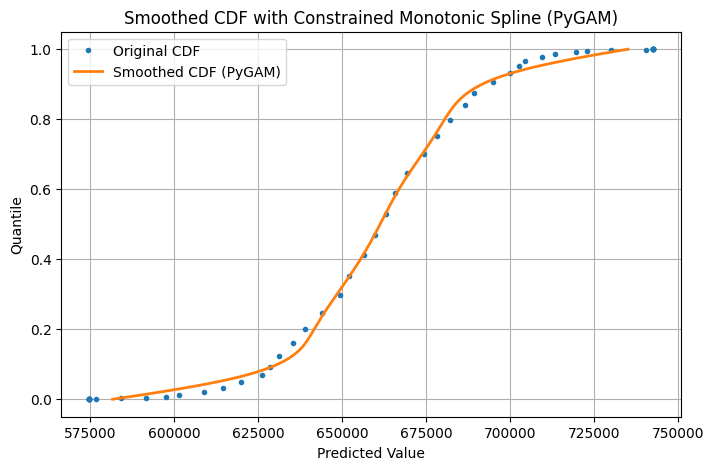

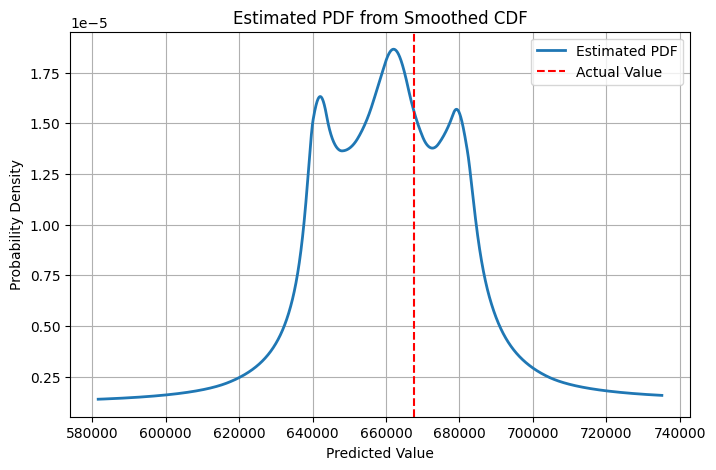

In [96]:
i=404

# Fit a monotonic increasing spline using PyGAM
y_pred_sample = y_pred[i].flatten()


# Fit a Generalized Additive Model with monotonic increasing constraint
gam = LinearGAM(s(0, constraints="monotonic_inc")).fit(quantiles, y_pred_sample)

# # Generate a smooth curve for prediction
quantiles_smooth = np.linspace(0, quantiles.max(), 10000)
y_pred_smooth = gam.predict(quantiles_smooth)


epsilon = 1e-10  # Small constant to avoid division by zero
# Compute PDF using central differences without modifying y_pred_smooth
pdf_smooth = np.gradient(quantiles_smooth, y_pred_smooth + epsilon)
# Ensure non-negative values (PDF should be non-negative)
pdf_smooth = np.maximum(pdf_smooth, 0)
# Normalize properly using numerical integration over y_pred_smooth
pdf_smooth /= np.trapz(pdf_smooth, y_pred_smooth)
# Check normalization
integral = np.trapz(pdf_smooth, y_pred_smooth)
print(f"Total integral of PDF: {integral}")  # Should print 1.


# Plot results
plt.figure(figsize=(8, 5))
plt.plot(y_pred_sample, quantiles, ".", label="Original CDF")  # Dots for raw CDF
plt.plot(y_pred_smooth, quantiles_smooth, "-", label="Smoothed CDF (PyGAM)", linewidth=2)
plt.xlabel("Predicted Value")
plt.ylabel("Quantile")
plt.title("Smoothed CDF with Constrained Monotonic Spline (PyGAM)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 5))
plt.plot(y_pred_smooth, pdf_smooth, "-", label="Estimated PDF", linewidth=2)
plt.axvline(x=y_test[i], color='red', linestyle='--', label='Actual Value')
plt.xlabel("Predicted Value")
plt.ylabel("Probability Density")
plt.title("Estimated PDF from Smoothed CDF")
plt.legend()
plt.grid(True)
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.show()

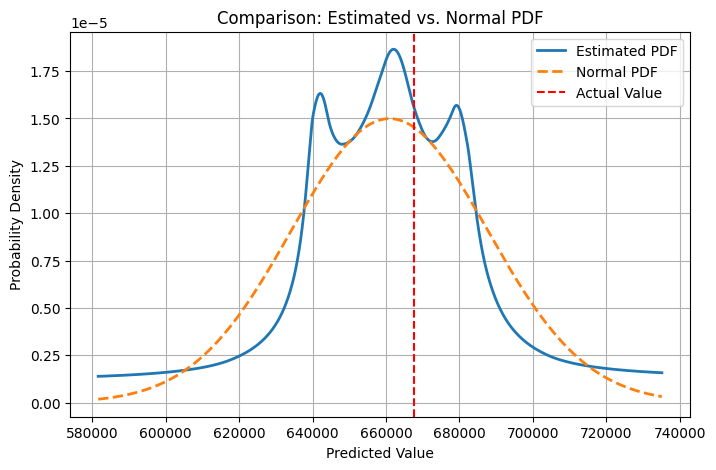

In [97]:
import scipy.stats as stats

plt.figure(figsize=(8, 5))
plt.plot(y_pred_smooth, pdf_smooth, "-", label="Estimated PDF", linewidth=2)

# Fit a normal distribution for comparison
mu, sigma = np.mean(y_pred_smooth), np.std(y_pred_smooth)
normal_pdf = stats.norm.pdf(y_pred_smooth, mu, sigma)
normal_pdf /= np.trapz(normal_pdf, y_pred_smooth)  # Normalize
plt.plot(y_pred_smooth, normal_pdf, "--", label="Normal PDF", linewidth=2)

plt.xlabel("Predicted Value")
plt.ylabel("Probability Density")
plt.title("Comparison: Estimated vs. Normal PDF")
plt.axvline(x=y_test[i], color='red', linestyle='--', label='Actual Value')
plt.legend()
plt.grid(True)
plt.show()


In [100]:
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s


# Define confidence levels to evaluate
confidence_levels = [0.9, 0.95]

# Initialize coverage results
coverage_results = {level: 0 for level in confidence_levels}

def compute_confidence_intervals(y_pred_smooth, pdf_smooth, confidence_level):
    """Computes confidence interval bounds for a given confidence level from the estimated PDF."""
    cdf_smooth = cumulative_trapezoid(pdf_smooth, y_pred_smooth, initial=0)
    
    lower_idx = np.searchsorted(cdf_smooth, (1 - confidence_level) / 2)
    upper_idx = np.searchsorted(cdf_smooth, 1 - (1 - confidence_level) / 2)
    
    lower_bound = y_pred_smooth[lower_idx]
    upper_bound = y_pred_smooth[upper_idx]
    
    return lower_bound, upper_bound

# Iterate through test set to compute coverage
num_samples = len(y_test)
for i in range(num_samples):
    y_pred_sample = y_pred[i].flatten()
    gam = LinearGAM(s(0, constraints="monotonic_inc")).fit(quantiles, y_pred_sample)
    
    # Generate smoothed CDF
    quantiles_smooth = np.linspace(0, quantiles.max(), 10000)
    y_pred_smooth = gam.predict(quantiles_smooth)
    
    # Compute PDF
    epsilon = 1e-10
    pdf_smooth = np.gradient(quantiles_smooth, y_pred_smooth + epsilon)
    pdf_smooth = np.maximum(pdf_smooth, 0)
    pdf_smooth /= np.trapz(pdf_smooth, y_pred_smooth)
    
    # Compute coverage for each confidence level
    for level in confidence_levels:
        lower, upper = compute_confidence_intervals(y_pred_smooth, pdf_smooth, level)
        if lower <= y_test[i] <= upper:
            coverage_results[level] += 1

# Normalize coverage results
for level in confidence_levels:
    coverage_results[level] /= num_samples

# Display results
for level, coverage in coverage_results.items():
    print(f"Coverage for {level*100:.1f}% CI: {coverage*100:.2f}%")


Coverage for 90.0% CI: 90.80%
Coverage for 95.0% CI: 95.60%
